## Import modules

In [1]:
# sklearn
from sklearn.datasets import fetch_openml

import numpy as np

import matplotlib.pyplot as plt

## Loading data

In [2]:
%%time
full_data = fetch_openml("mnist_784")

CPU times: user 17 s, sys: 280 ms, total: 17.3 s
Wall time: 17.3 s


In [3]:
full_data.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
full_data['target'].shape

(70000,)

In [5]:
train_size = 60000
test_size = 10000

## Separate full_data to train and test

In [6]:
train_data = {'data': full_data['data'][:train_size], 'target': full_data['target'][:train_size]}
test_data = {'data': full_data['data'][train_size:], 'target': full_data['target'][train_size:]}

## Let's visualize first 10 digits from train:

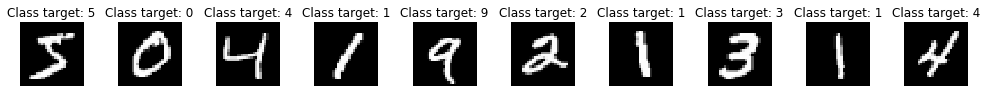

In [7]:
digits_to_show = 10
fig = plt.figure(figsize=(15, 15))
for i in range(digits_to_show):
    ax = fig.add_subplot(1, digits_to_show + 1, i+1)
    ax.imshow(train_data['data'][i].reshape(28, 28), cmap=plt.get_cmap('Greys_r'))
    ax.set_title('Class target: ' + train_data['target'][i])
    ax.axis("off")
plt.tight_layout()
plt.show()

## Testing my KNNClassifier

In [8]:
train_data['target'] = train_data['target'].astype(int)
test_data['target'] = test_data['target'].astype(int)

In [9]:
import numpy as np
from nearest_neighbors import KNNClassifier


def kfold(n, n_folds=5):
    """
    params:
        * n - objects amount in sample
        * n_folds - folds amount
    return values:
        * list with size n_folds, where every element is tuple of two 1D numpy array:
            * first array contains indices of train samples
            * second array contains indices of validation samples
    """

    indices = np.arange(n)
    folds = np.array_split(indices, n_folds)
    train_test_idx_list = []
    for fold in folds:
        test_idx = fold
        train_idx = list(set(folds) - set(fold))
        train_test_idx_list.append((train_idx, test_idx))
    return train_test_idx_list


def accuracy(y_valid, y_true):
    return np.sum(y_valid == y_true, axis=0) / len(y_valid) * 100


def knn_cross_val_score(X, y, k_list, score='accuracy', cv=None, **kwargs):
    """
    :param X: train samples
    :param y: targets for train
    :param k_list: list of values of neighbors amount, in ascending order
    :param score: metric name( accuracy' must have)
    :param cv: list of tuples, which contains indices of train and valid samples
    :param kwargs: parameters for __init__ from KNNClassifier
    :return: dict, where keys is neigbors amount from k_list, values - numpy array of size len(cv)
    with accuracy on each fold
    """

    if cv is None:
        cv = kfold(X.shape[0])
    knn = KNNClassifier(**kwargs)
    knn.k = np.max(k_list)
    knn.fit(X, y)
    knn.find_kneighbors(X, return_distance=True)
    accuracy_per_k = {k: np.empty(0) for k in k_list}
    for k in k_list:
        knn.k = k
        for fold in cv:
            y_valid = knn.predict(X[fold[1]])
            accuracy_per_k[k] = np.append(accuracy_per_k[k],
                                          accuracy(y_valid,
                                                   y[fold[1]]))
    return accuracy_per_k



In [497]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from distances import euclidean_distance, cosine_distance


class KNNClassifier:
    def __init__(self,
                 k=10,
                 strategy='my_own',
                 metric='euclidean',
                 weights=False,
                 test_block_size=100
                 ):
        """
        params:
            * k - amount of nearest neighbours(nn)
            * strategy - nn searching algorithm. Possible values:
                - 'my_own' - self-realization
                - 'brute' - from sklearn.neighbors.NearestNeighbors(algorithm='brute')
                - 'kd_tree' - from sklearn.neighbors.NearestNeighbors(algorithm='kd_tree')
                - 'ball_tree' - from sklearn.neighbors.NearestNeighbors(algorithm='ball_tree')
            * metric:
                - 'euclidean' - euclidean metric
                - 'cosine' - cosine metric
            * weights - bool variable.
                - True - weighted KNN(with distance)
                - False - simple KNN
            * test_block_size - size of test block
        """

        self.X_train = None
        self.y_train = None
        self.distances = None
        self.neigh_idxs = None
        self.model = None
        self.k = k
        self.strategy = strategy
        self.metric = metric
        self.eps = 1e-5
        self.weights = weights
        if self.strategy == 'brute':
            self.model = NearestNeighbors(n_neighbors=self.k, algorithm=self.strategy, metric=self.metric)
        elif self.strategy != 'my_own':
            self.model = NearestNeighbors(n_neighbors=self.k, algorithm=self.strategy)
        else:
            self.model = None
        self.test_block_size = test_block_size

    def fit(self, X, y):
        """
        params:
            * X - train data
            * y - targets for train data
        """

        self.y_train = y.astype(int)
        self.k = np.min([self.y_train.shape[0], self.k])
        if self.strategy != 'my_own':
            self.model.fit(X, self.y_train)
        else:
            self.X_train = X

    def find_kneighbors(self, X, return_distance):
        """
        params:
            * X - objects sample
            * return_distance - bool variable

        return values:
            * If return_distance == True:
                * tuple with two numpy array with size (X.shape[0], k), where:
                  [i, j] elem of first array must be the distance between
                  i-th object and his j-th nearest neighbour
                  [i, j] elem of second array must be the index of j-th nearest neighbour to i-th object
            * If return_distance == False:
                * only second array
        """
        
        if self.strategy != 'my_own':
            distances, \
            neigh_idxs = self.model.kneighbors(X, n_neighbors=self.k)
        else:
            if self.metric == 'euclidean':
                distances = euclidean_distance(X, self.X_train)
                neigh_idxs = np.argsort(distances,
                                             axis=1)[:, :self.k]
                if return_distance:
                    distances = np.sort(distances,
                                             axis=1)[:, :self.k]

            elif self.metric == 'cosine':
                distances = cosine_distance(X, self.X_train)
                neigh_idxs = np.argsort(distances,
                                             axis=1)[:, :self.k]
                if return_distance:
                    distances = np.sort(distances,
                                        axis=1)[:, :self.k]
        if return_distance:
            return distances, neigh_idxs
        return neigh_idxs

    def predict(self, X):
        """
        params:
            * X - test objects

        return values:
            * numpy array with size X.shape[0] of predictions for test objects from X
        """

        if self.test_block_size > X.shape[0]:
            self.test_block_size = X.shape[0]
        preds = np.zeros(X.shape[0])
        split_size = X.shape[0] // self.test_block_size + \
                     int(X.shape[0] % self.test_block_size != 0)
        classes = np.array(np.unique(self.y_train))
        last_idx = 0
        for i, split in enumerate(np.array_split(X, split_size)):
            distances, neigh_idxs = self.find_kneighbors(split, True)
            for j, idx in enumerate(neigh_idxs):
                counts = np.zeros(len(classes))
                for c in classes:
                    if self.weights:
                        weights = 1 / (distances[j] + self.eps)
                        counts[c] = np.sum((self.y_train[idx] == c) * weights)
                    else:
                        counts[c] = np.sum(self.y_train[idx] == c)
                preds[j + i * split.shape[0]] = np.argmax(counts)
        distances, neigh_idxs = self.find_kneighbors(X[last_idx:], True)
        for j, idx in enumerate(neigh_idxs):
            counts = np.zeros(len(classes))
            for c in classes:
                if self.weights:
                    weights = 1 / (distances[j] + self.eps)
                    counts[c] = np.sum((self.y_train[idx] == c) * weights)
                else:
                    counts[c] = np.sum(self.y_train[idx] == c)
                preds[last_idx+j] = np.argmax(counts)
        return preds


n_test_samples = 1000

In [512]:
KNN_model = KNNClassifier(5, strategy='my_own', metric='euclidean', weights=False, test_block_size=44)

In [513]:
%%time
KNN_model.fit(X=train_data['data'][:5000], y=train_data['target'])

CPU times: user 225 µs, sys: 0 ns, total: 225 µs
Wall time: 148 µs


In [514]:

# KNN_model.find_kneighbors(test_data['data'][:n_test_samples], False)
#14.4 - True # 500 samples
#9.56 - False # 500 samples

#2min 48s - True # 10k samples
#2min 11s - False # 10k samples

In [515]:
# array([[53843, 38620, 16186, 27059, 47003],
#        [28882, 49160, 24612, 31634, 16902],
#        [58741, 46512, 15224, 47333, 44038],
#        ...,
#        [46124, 13852, 17844, 18510, 33708],
#        [29034, 43258, 56724, 43706, 19908],
#        [49436, 41800, 50670, 11132, 55520]])

In [516]:
%%time
preds1 = KNN_model.predict(test_data['data'][:n_test_samples])
#12.5 s - True # 500 samples
#9.47 s - False # 500 samples

# 6min 53s - True # 10k samples
# 6min 16s - False # 10k samples
#(1, 5, 60000)
#(100, 5)

CPU times: user 11.5 s, sys: 168 ms, total: 11.6 s
Wall time: 1.58 s


In [517]:
# arr_my = KNN_model.find_kneighbors(test_data['data'][:n_test_samples], return_distance=False)

In [518]:
sum(preds1.astype(int) - test_data['target'][:n_test_samples].astype(int) == 0) / test_data['target'][:n_test_samples].size

0.91

In [346]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(5, algorithm='brute', metric='euclidean', weights='distance')
knn.fit(X=train_data['data'], y=train_data['target'])

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [43]:
preds1 = knn.predict(test_data['data'][:n_test_samples])

In [44]:
sum(preds1.astype(int) - test_data['target'][:n_test_samples].astype(int) == 0) / test_data['target'][:n_test_samples].size

0.964

(228, 784)

## Testing distances

In [ ]:
import numpy as np
from distances import euclidean_distance, cosine_distance

In [ ]:
x = np.array([[2, 3], [-1, 6], [10, 22]])
y = np.array([[1, 1], [-1, 2]])

In [ ]:
cosine_distance(x, y)

In [ ]:
from scipy.spatial.distance import pdist

In [ ]:
pdist(test_arr)

In [ ]:
import numpy as np


# def cosine_distance(X, Y):
#     """
#     params:
#         * X - np.array with size N x D
#         * Y - np.array with size M x D
#     return values:
#         * np.array with size N x M, where [i, j] - cosine distance between i-th vector from X and
#                                                                               j-th vector from Y
#     """
    
#     X = X[None, :, :]
#     Y = Y[:, None, :]
#     result = np.sum(X * Y, axis=2)
#     result /= np.sqrt(np.sum(X ** 2, axis=2))
#     result /= np.sqrt(np.sum(Y ** 2, axis=2))
#     return 1 - result

def euclidean_distance(X, Y):
    """
    params:
        * X - np.array with size N x D
        * Y - np.array with size M x D
    return values:
        * np.array with size N x M, where [i, j] - euclidean distance between i-th vector from X and
                                                                              j-th vector from Y
    """

    X_sqr = np.sum(X ** 2, axis=1)[:, None]
    print(X_sqr.shape)
    Y_sqr = np.sum(Y ** 2, axis=1)
    print(Y_sqr.shape)
    return np.sqrt(X_sqr - 2 * np.dot(X, Y.T) + Y_sqr)

In [ ]:
X = np.arange(1, 10000)
np.sum(X[[1, 2, 5, 6]])

In [ ]:
%load_ext memory_profiler

In [ ]:
%%time
%%memit
print(euclidean_distance(np.ones((2000, 1000)) * 5, np.ones((500, 1000))))
#2.22 s - new on 200x500

#763 ms - old on 200x500
#7725.48 


In [ ]:
np.shape(X[None, ...] - Y[:, None, :])

In [ ]:
%%time
std_norm = np.linalg.norm(X, axis=1)
print('done')

In [ ]:
%%time
my_norm = np.sqrt(np.sum(X ** 2, axis=1))
print('done')

In [ ]:
sum(std_norm != my_norm)

## Testing cross_validation

In [ ]:
import numpy as np
from nearest_neighbors import KNNClassifier


def kfold(n, n_folds=5):
    """
    params:
        * n - objects amount in sample
        * n_folds - folds amount
    return values:
        * list with size n_folds, where every element is tuple of two 1D numpy array:
            * first array contains indices of train samples
            * second array contains indices of validation samples
    """
    
    indices = np.arange(n)
    size_of_one_fold = int(n / n_folds)
    size_with_folds = size_of_one_fold * n_folds
    out_elemnts_amount = len(indices) - size_with_folds
    train_test_idx_list = []
    for i in range(n_folds):
        test_idx = indices[i * size_of_one_fold:(i + 1) * size_of_one_fold]
        if out_elemnts_amount > 0:
            test_idx = np.append(test_idx, n - out_elemnts_amount)
            out_elemnts_amount -= 1
        train_idx = np.array(list((set(indices) - set(test_idx))))
        train_test_idx_list.append((train_idx, test_idx))
    return train_test_idx_list
    
def accuracy(y_valid, y_true):
    return np.sum(y_valid == y_true, axis=0) / len(y_valid) * 100


def knn_cross_val_score(X, y, k_list=[2, 3, 5, 10, 15], score='accuracy', cv=None, **kwargs):
    """
    :param X: train samples
    :param y: targets for train
    :param k_list: list of values of neighbors amount, in ascending order
    :param score: metric name( accuracy' must have)
    :param cv: list of tuples, which contains indices of train and valid samples
    :param kwargs: parameters for __init__ from KNNClassifier
    :return: dict, where keys is neigbors amount from k_list, values - numpy array of size len(cv)
    with accuracy on each fold
    """
    
    if cv is None:
        cv = kfold(X.shape[0])
    knn = KNNClassifier(**kwargs)
    knn.k = np.max(k_list)
    knn.fit(X, y)
    knn.find_kneighbors(X, return_distance=True)
    accuracy_per_k = {k: np.empty(0) for k in k_list}
    for k in k_list:
        knn.k = k
        for fold in cv:
            y_valid = knn.predict(X[fold[1]])
            accuracy_per_k[k] = np.append(accuracy_per_k[k],
                      accuracy(y_valid,
                               y[fold[1]]))
    return accuracy_per_k
    

In [ ]:
import numpy as np
from nearest_neighbors import KNNClassifier


def kfold(n, n_folds=5):
    """
    params:
        * n - objects amount in sample
        * n_folds - folds amount
    return values:
        * list with size n_folds, where every element is tuple of two 1D numpy array:
            * first array contains indices of train samples
            * second array contains indices of validation samples
    """

    indices = np.arange(n)
    folds = np.array_split(indices, n_folds)
    train_test_idx_list = []
    for i, fold in enumerate(folds):
        test_idx = fold
        train_idx = folds[:i] + folds[i + 1:]
        train_test_idx_list.append((train_idx, test_idx))
    return train_test_idx_list


def accuracy(y_valid, y_true):
    return np.sum(y_valid == y_true, axis=0) / len(y_valid) * 100


def knn_cross_val_score(X, y, k_list, score='accuracy', cv=None, **kwargs):
    """
    :param X: train samples
    :param y: targets for train
    :param k_list: list of values of neighbors amount, in ascending order
    :param score: metric name( accuracy' must have)
    :param cv: list of tuples, which contains indices of train and valid samples
    :param kwargs: parameters for __init__ from KNNClassifier
    :return: dict, where keys is neigbors amount from k_list, values - numpy array of size len(cv)
    with accuracy on each fold
    """

    if cv is None:
        cv = kfold(X.shape[0])
    knn = KNNClassifier(**kwargs)
    knn.k = np.max(k_list)
    knn.fit(X, y)
    knn.find_kneighbors(X, return_distance=True)
    accuracy_per_k = {k: np.empty(0) for k in k_list}
    for k in k_list:
        knn.k = k
        for fold in cv:
            y_valid = knn.predict(X[fold[1]])
            accuracy_per_k[k] = np.append(accuracy_per_k[k],
                                          accuracy(y_valid,
                                                   y[fold[1]]))
    return accuracy_per_k


In [ ]:
knn_cross_val_score(train_data['data'][:1000],
                    train_data['target'][:1000],
                    k_list=[3, 4, 10, 50, 200],
                    score='accuracy',
                    cv=None,
                    k=10,
                    strategy='my_own',
                    metric='euclidean',
                    weights=False,
                    test_block_size=100
                   )

In [ ]:
kfold(50, 5)

In [ ]:
# 3: array([94.5, 92.5, 92.5, 89.5, 93.5]),
#  4: array([93.5, 91.5, 91. , 89.5, 93. ]),
#  10: array([90.5, 88.5, 88.5, 84. , 90. ]),
#  50: array([78. , 83. , 79. , 76. , 83.5]),
#  200: array([60. , 68. , 54.5, 58.5, 57. ])}

In [ ]:
k_list1 = [1, 2, 3, 4, 5, 10]
accuracy_per_k = {k: np.empty(0) for k in k_list1}

In [ ]:
accuracy_per_k[1] = np.append(accuracy_per_k[1], 5)

In [ ]:
accuracy_per_k[1]

In [ ]:
k_list1.index(5)